Rede criada: n=10000, <k>=18.96, <k²>=3179.29


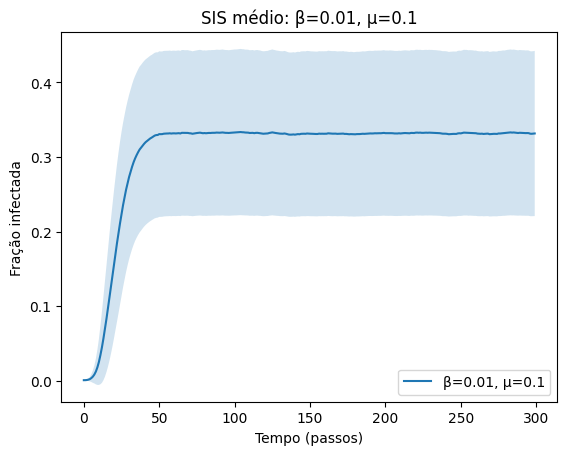

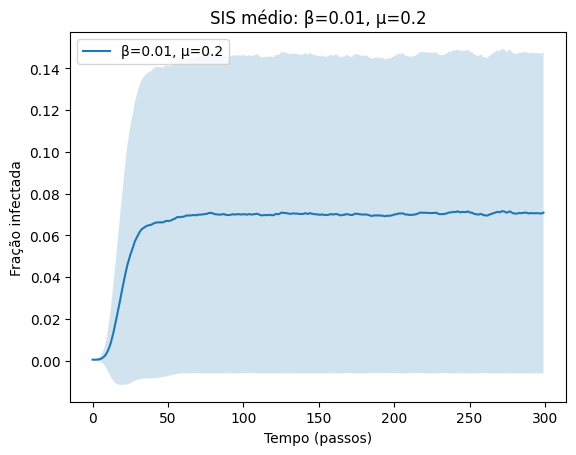

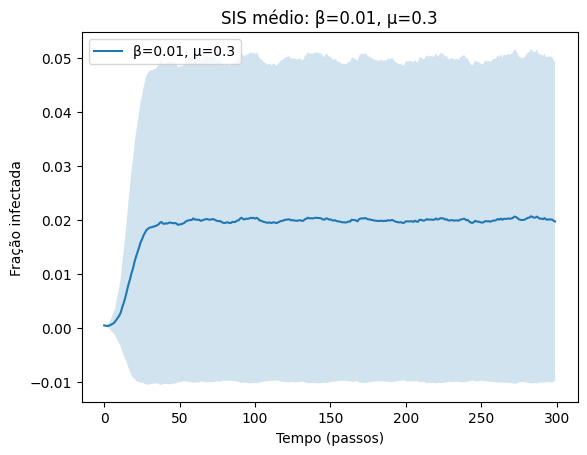

      β    μ       β/μ  Prevalência média  Desvio-padrão
0  0.01  0.1  0.100000           0.331913       0.110900
1  0.01  0.2  0.050000           0.070647       0.076699
2  0.01  0.3  0.033333           0.020023       0.030029


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse

n = 10_000
gamma = 2.5
target_k = 20.0
rng = np.random.default_rng(42)

# Rede livre de escala
def sample_powerlaw_degrees(n, gamma, target_mean):
    alpha = gamma - 1.0
    xm = target_mean * (alpha - 1.0) / alpha
    vals = (rng.pareto(alpha, size=n) + 1) * xm
    degs = np.rint(vals).astype(int)
    degs[degs < 1] = 1
    if degs.sum() % 2 == 1:
        degs[0] += 1
    return degs

degrees = sample_powerlaw_degrees(n, gamma, target_k)
G = nx.expected_degree_graph(degrees.tolist(), selfloops=False)
A = nx.to_scipy_sparse_array(G, format="csr", dtype=np.int8)

deg_list = np.array([d for _, d in G.degree()])
emp_k = deg_list.mean()
emp_k2 = np.mean(deg_list.astype(float)**2)
print(f"Rede criada: n={n}, <k>={emp_k:.2f}, <k²>={emp_k2:.2f}")

# Simulação SIS (100 execuções)
def simulate_SIS_sparse(A, beta, mu, T=300, runs=100):
    rng_local = np.random.default_rng(123)
    n = A.shape[0]
    prevalence_runs = np.zeros((runs, T))

    for r in range(runs):
        infected = np.zeros(n, dtype=bool)
        infected[rng_local.choice(n, 5, replace=False)] = True

        for t in range(T):
            prevalence_runs[r, t] = infected.mean()

            # recuperação
            recover = infected & (rng_local.random(n) < mu)
            infected[recover] = False

            # infecção
            inf_counts = A.dot(infected.astype(np.int8))
            susceptible = ~infected
            k_inf = inf_counts[susceptible]
            p_inf = 1.0 - np.power(1.0 - beta, k_inf)
            new_inf = rng_local.random(len(k_inf)) < p_inf
            infected[susceptible] = new_inf

    mean_prev = prevalence_runs.mean(axis=0)
    std_prev = prevalence_runs.std(axis=0)
    return mean_prev, std_prev

# Executando simulações com os diferentes parâmetros
params = [(0.01, 0.1), (0.01, 0.2), (0.01, 0.3)]
results = {}

for beta, mu in params:
    mean_prev, std_prev = simulate_SIS_sparse(A, beta, mu)
    results[(beta, mu)] = (mean_prev, std_prev)
    plt.figure()
    plt.plot(mean_prev, label=f"β={beta}, μ={mu}")
    plt.fill_between(np.arange(len(mean_prev)), mean_prev-std_prev, mean_prev+std_prev, alpha=0.2)
    plt.xlabel("Tempo (passos)")
    plt.ylabel("Fração infectada")
    plt.title(f"SIS médio: β={beta}, μ={mu}")
    plt.legend()
    plt.show()

# Resultados
rows = []
for beta, mu in params:
    mean_prev, std_prev = results[(beta, mu)]
    ss_mean = mean_prev[-100:].mean()
    ss_std = std_prev[-100:].mean()
    tau = beta / mu
    rows.append({
        "β": beta, "μ": mu, "β/μ": tau,
        "Prevalência média": ss_mean,
        "Desvio-padrão": ss_std
    })

df = pd.DataFrame(rows)
print(df)


Através da tabela e gráficos acima, podemos observar a diferença nas simulações epidemiológicas variando a **taxa de recuperação μ** enquanto a **taxa de infecção β** permanece constante. 

No cenário onde β = 0.01 e  μ = 0.1 vemos que a infecção é prevalente sobre a recuperação, ou seja, a epidemia se sustenta no tempo com uma prevalência média de 33% nos últimos 100 passos. O desvio-padrão 0.11 indica flutuações entre as simulações, mas com presença contínua de infectados, atingindo assim um estado endêmico estável.

Já no cenário onde β = 0.01 e μ = 0.2 a recuperação é mais rápida, reduzindo a proporção de infectados ativos. A prevalência média nesse caso já cai para cerca de 7%, mostrando que a infecção ainda se mantém, mas em um nível estável baixo. O desvio-padrão menor (0.077) indica uma dinâmica mais estávelentre as simulações.

Por último, o caso onde β = 0.01 e μ = 0.3 a taxa de recuperação é alta, ou seja, a infecção quase não consegue se manter, resultando em uma prevalência baixa (2%). O desvio-padrão pequeno mostra que o sistema está próximo de um estado livre de doença, com infecções esporádicas e transitórias.

Assim, podemos observar que à medida que μ aumenta (probabilidade maior de recuperação) o sistema passa de um regime de alta prevalência para um regime onde a doença desaparece.  

Comparando com a questão acima, que é o caso onde a rede é aleatória, podemos observar que os resultados são muito parecidos. No primeiro cenário onde o μ é baixo temos um estado endêmico que diminui a medida que a taxa de recuperação aumenta.
